In [21]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, SubsetRandomSampler
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

### Deep NN on GPU with Pytorch

In [2]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [7]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [10]:
img, label = dataset[0]
img.shape, label

(torch.Size([1, 28, 28]), 5)

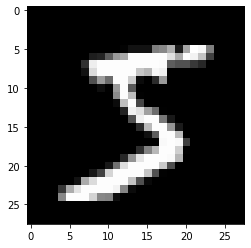

In [13]:
plt.imshow(img[0], cmap = 'gray')

In [14]:
img[0, 10:15, 10:15]

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])

Split Data

In [15]:
def split_indices(n, val_pct):
  #determine size of val set

  n_val = int(val_pct*n)

  #create rand permutations of 0 to n-1

  indxs = np.random.permutation(n)

  #pick first n_val indices for val set

  return indxs[n_val:], indxs[:n_val]

In [17]:
#train_indices, val_indices = split_indices(len(dataset), val_pct = 0.2)

In [19]:
# print(len(train_indices), len(val_indices))
# print(val_indices[:20])

48000 12000
[ 7966 30747 33354 58131 23546  9822 44855 57963 43764 34765  2479 27766
 24387 40122 49054 22136 38296 33150 42728 45861]


In [29]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [30]:
batch_size = 128

#creating train and val loader

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 1, 28, 28])


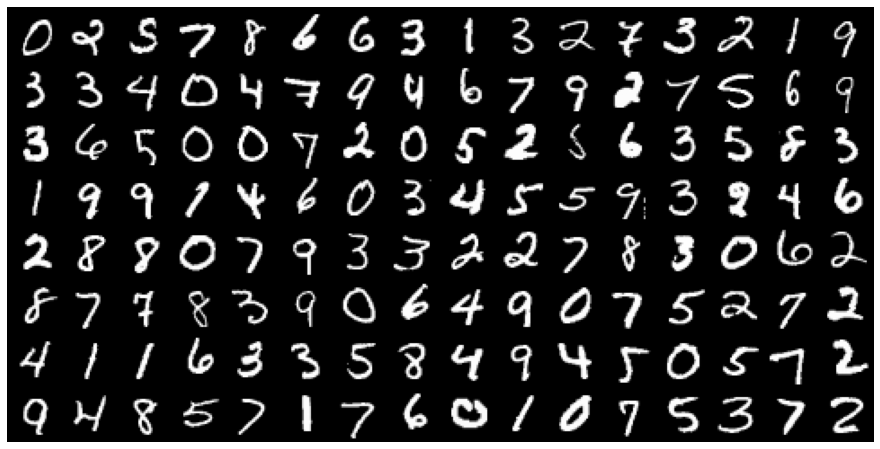

In [31]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [35]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [36]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [37]:
input_size = 784
num_classes = 10
hidden_size = 32

model = MnistModel(input_size, hidden_size, out_size = num_classes)

In [38]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [39]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Loss: 2.2996106147766113
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.1110,  0.0768,  0.2143,  0.0891,  0.2096, -0.0631,  0.1859, -0.2484,
         -0.1481, -0.0789],
        [-0.0834,  0.1047,  0.2286, -0.0760,  0.1421, -0.0256,  0.1667, -0.1743,
         -0.0988, -0.0554]])


In [41]:
torch.cuda.is_available()

False

In [42]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [43]:
device = get_default_device()
device

device(type='cpu')

In [44]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [45]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
cpu


In [46]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [47]:
def some_numbers():
    yield 10
    yield 20
    yield 30

for value in some_numbers():
    print(value)

10
20
30


In [48]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [49]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


xb.device: cpu
yb: tensor([8, 3, 1, 7, 2, 7, 6, 9, 4, 6, 7, 8, 8, 6, 1, 1, 2, 1, 5, 4, 1, 9, 3, 6,
        6, 1, 5, 4, 8, 1, 9, 9, 4, 5, 9, 8, 7, 2, 0, 2, 3, 9, 5, 6, 0, 1, 8, 2,
        7, 6, 0, 0, 0, 0, 0, 2, 0, 3, 7, 9, 1, 1, 8, 9, 9, 1, 7, 5, 2, 8, 4, 4,
        2, 9, 1, 7, 0, 4, 4, 5, 1, 1, 7, 3, 8, 2, 6, 3, 7, 1, 9, 1, 6, 4, 9, 2,
        6, 7, 9, 0, 4, 2, 5, 8, 4, 0, 0, 1, 6, 5, 2, 1, 8, 9, 0, 6, 5, 1, 4, 1,
        6, 8, 8, 1, 6, 6, 8, 1, 9, 1, 1, 0, 5, 7, 0, 8, 1, 7, 5, 9, 8, 3, 1, 4,
        6, 0, 9, 5, 3, 3, 6, 2, 9, 7, 4, 3, 3, 4, 1, 9, 9, 1, 6, 5, 1, 4, 8, 7,
        6, 1, 1, 1, 5, 8, 4, 5, 8, 1, 1, 9, 0, 7, 2, 5, 2, 0, 2, 1, 8, 3, 2, 1,
        3, 4, 4, 1, 1, 4, 3, 9, 0, 2, 1, 6, 8, 6, 1, 7, 2, 8, 7, 3, 2, 0, 7, 2,
        8, 8, 2, 8, 7, 5, 9, 8, 1, 5, 0, 0, 8, 7, 4, 0, 7, 3, 5, 8, 4, 7, 3, 1,
        2, 7, 9, 1, 8, 9, 6, 0, 9, 3, 9, 0, 7, 1, 1, 8])


In [50]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [51]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [52]:
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.07314453274011612, 'val_loss': 2.3169631958007812}]

In [53]:
history += fit(5, 0.5, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.2554, val_acc: 0.9235
Epoch [1], val_loss: 0.2613, val_acc: 0.9238
Epoch [2], val_loss: 0.1856, val_acc: 0.9444
Epoch [3], val_loss: 0.1705, val_acc: 0.9523
Epoch [4], val_loss: 0.1543, val_acc: 0.9560


In [54]:
history += fit(5, 0.1, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.1281, val_acc: 0.9641
Epoch [1], val_loss: 0.1284, val_acc: 0.9632
Epoch [2], val_loss: 0.1272, val_acc: 0.9649
Epoch [3], val_loss: 0.1278, val_acc: 0.9659
Epoch [4], val_loss: 0.1235, val_acc: 0.9659


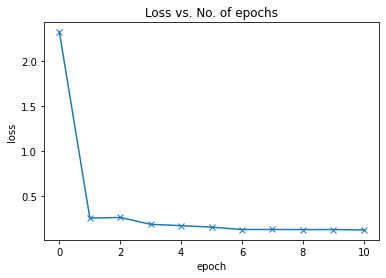

In [55]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

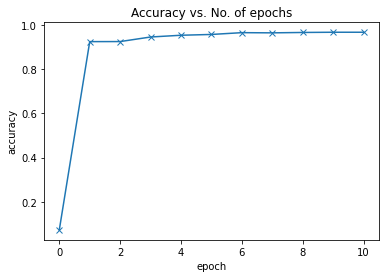

In [56]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

### Test

In [57]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [58]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


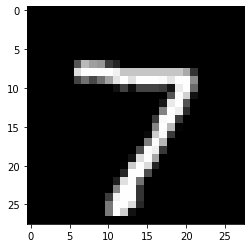

In [59]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 3 , Predicted: 3


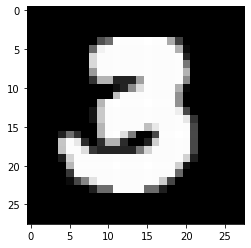

In [60]:
img, label = test_dataset[200]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 5 , Predicted: 5


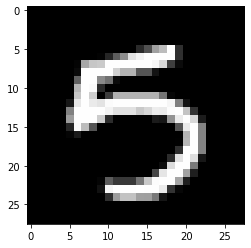

In [61]:
img, label = test_dataset[588]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [62]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.96875, 'val_loss': 0.10003998130559921}

In [64]:
torch.save(model.state_dict(), 'mnist-feedforward.pth')